# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using explicit circuits obtained from more basic and special purpose functions
## 3. The same is done using the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q3l/sgd_10q_3l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-12 22:50:46]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-12 22:50:46]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.560174594055583. 
The target energy is -15.276131122065795 which means the difference is 0.7159565280102118.
The relative difference is 0.04686766055418572%.


# 2. try gradient descent
$D= \sum_i B_i Z_i$
and Group commutator

In [4]:
b_list = [1+np.sin(x) for x in range(nqubits) ]
#b_list = [-0.25024438, -0.12512219, -0.06256109, -0.03128055, -0.01564027, -0.00782014,
 -0.00391007, -0.00195503, -0.00097752, -0.00048876]
len(b_list)


10

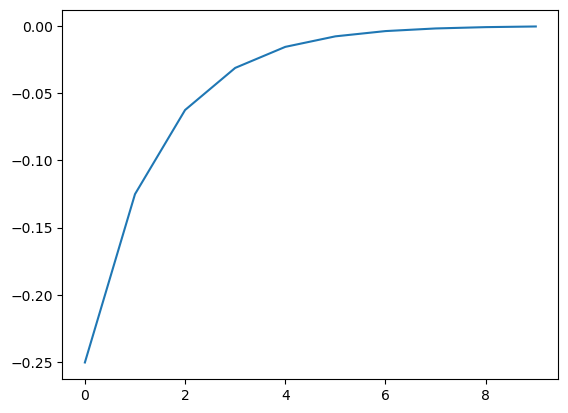

In [5]:
#b_list = np.random.rand(nqubits)
d = hamiltonians.SymbolicHamiltonian( sum([b*symbols.Z(j) for j,b in zip(range(nqubits),b_list)]))

plt.plot(b_list)

In [6]:


from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

# quick hack how to use the method function hamiltonians.XXZ to get a simulable oracle
hamiltonian.delta = 0.5
hamiltonian.dense = hamiltonian
eo_xxz = XXZ_EvolutionOracle(hamiltonian,mode_evolution_oracle=EvolutionOracleType.numerical, steps = 1, order = 2)
eo_xxz.mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation
#hack end

# prescribe nmb of steps, otherwise there will be casting to dense and searching for a step duration (this can later be avoided with @shangtai non-classical simulation PR)
eo_xxz.please_use_prescribed_nmb_ts_steps = 1

# implement the rotate by VQE on the level of circuits
fsoe  = FrameShiftedEvolutionOracle(eo_xxz, before_circuit=vqe.circuit.invert(), 
                                                        after_circuit=vqe.circuit,name="shifting by vqe")

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci.h_ref = deepcopy(hamiltonian)
# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = EvolutionOracle(d,mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation,name = "D(linear)")
eo_d.please_use_prescribed_nmb_ts_steps = 1
step,loss = gci.choose_step(d = eo_d)
# above we didn't gauge the time \approx e^{x^2 [D,H]} but gci approximates e^{-sW} so takes a square root
circ_boost = (  gci.group_commutator(step, eo_d)["forwards"] +vqe.circuit )

hamiltonian.expectation(circ_boost().state()) 

-14.55883015461238

In [7]:
def gradient_numerical_circuits(
    dbi_object: DoubleBracketIteration,
    d_params: list,
    parameterization: ParameterizationTypes,
    s: float = 1e-2,
    delta: float = 1e-3,
    backend=None,
    loss_0 = None,
    **kwargs,
):
    r"""
    Gradient of the DBI with respect to the parametrization of D. A simple finite difference is used to calculate the gradient.

    Args:
        dbi_object (DoubleBracketIteration): DoubleBracketIteration object.
        d_params (np.array): Parameters for the ansatz (note that the dimension must be 2**nqubits for full ansazt and nqubits for Pauli ansatz).
        s (float): A short flow duration for finding the numerical gradient.
        delta (float): Step size for numerical gradient.
    Returns:
        grad (np.array): Gradient of the D operator.
    """

    nqubits = dbi_object.nqubits
    grad = np.zeros(len(d_params))
    d = params_to_diagonal_operator(
        d_params, nqubits, parameterization=parameterization, **kwargs
    )
    if loss_0 is None:
        loss_0 = dbi_object.loss(s, d)
    for i in range(len(d_params)):
        params_new = deepcopy(d_params)
        params_new[i] += delta
        d_new = params_to_diagonal_operator(
            params_new, nqubits, parameterization=parameterization, **kwargs
        )
        # find the increment of a very small step
        grad[i] = (dbi_object.loss(s, d_new) - loss_0 ) / delta
    return grad

In [8]:
grad = gradient_numerical_circuits(
    gci,
    b_list,
    ParameterizationTypes.circuits,
    s=1e-4
)

In [9]:
grad

array([-0.00023595, -0.00029018, -0.00031306, -0.00034537, -0.0003095 ,
       -0.00021277, -0.00031808, -0.00039002, -0.00026142, -0.0002493 ])

In [10]:
def gradient_descent_circuits(
    dbi_object: DoubleBracketIteration,
    train_epochs: int,
    d_params_init: list,
    lr: float = 1e-2,
    step_guess = 0.01
):

    nqubits = dbi_object.nqubits

    d_params_store = []
    s_store = []
    loss_store = []


    d_init = params_to_diagonal_operator(
                d_params_init,
                nqubits,
                parameterization=ParameterizationTypes.circuits
            )
    s,loss = gci.choose_step(d = d_init, max_evals = 50)
    print(loss)
    d_params_test = d_params_init
    for i in range(train_epochs):
        print(i)
        # find gradient
        grad = gradient_numerical_circuits(
            dbi_object,
            d_params_test,
            ParameterizationTypes.circuits,
            s=0.004,
            loss_0 = loss
        )
        d_params_store_lr = []
        s_store_lr = []
        loss_store_lr = []
        for lr in np.linspace(1,1e3,9):
            d_params_test = [d_params_init[j] - grad[j] * lr for j in range(len(grad))]
            d = params_to_diagonal_operator(
                d_params_test,
                nqubits,
                parameterization=ParameterizationTypes.circuits
            )
            #step_guess, loss = dbi_object.choose_step(d=d,step_min=1e-5,step_max=0.1, max_evals=35,verbose=False)
            print(loss)

            d_params_store_lr.append(d_params_test)
            s_store_lr.append(step_guess)
            loss_store_lr.append(loss)
        # store values
        loss = min(loss_store_lr)

        idx_min = loss_store_lr.index(loss)

        d_params_test = d_params_store_lr[idx_min]  
        d_params_store.append(d_params_test)      
        step_guess = s_store_lr[idx_min]
        s_store.append(step_guess)
        loss_store.append(loss)

        print(loss_store_lr[idx_min])
        # choose the minimum loss from store
    min_loss = min(loss_store)
    idx_min = loss_store.index(min_loss)
    d_params_test = d_params_store[idx_min]
    s = s_store[idx_min]

    return d_params_test, s, min_loss

In [11]:
d_params_test, s, min_loss = gradient_descent_circuits(
gci,
 train_epochs=1,
   d_params_init=b_list,
   lr=1
)

-14.55883015461235
0
-14.765763051133575
-14.56396888543918
-14.556996750058786
-14.559534222271996
-14.560317782059034
-14.648238051004892
-14.557038994906328
-14.563321090748923


KeyboardInterrupt: 

In [ ]:
np.max(np.array(d_params_test) - np.array(b_list))

-0.013923057065984068

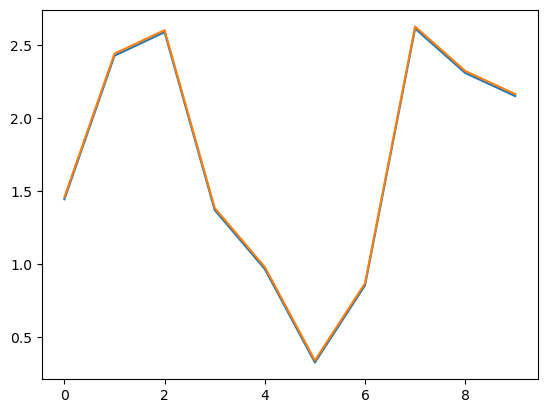

In [ ]:
plt.plot(d_params_test)
plt.plot(b_list)

In [ ]:
step,loss = gci.choose_step(d = eo_d,step_min=0.0001,step_max=1.15*0.01, max_evals=25)

In [ ]:
loss

-14.768439513327529

In [ ]:
step

0.011025